# Some plots

## Distributions of training- and test data

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display
from IPython.display import Audio

import sys
import os
sys.path.append("../scripts")

In [24]:
class cfg:
    # random seed
    seed = 42

    # audio clip settings
    sr = 22050
    duration = 15 # the duration of the clips
    
    n_samples = duration*sr
    
    hop_length = 2048 # "stepsize" of the fft for the melspectrograms
    nfft = 4096 # windowsize of the fft for the melspectrograms
    n_mels = 128 # number of mel frequency bins
    fmax = sr/2 # maximum frequency in the melspectrograms
    input_dim = (n_mels, int(duration*sr//hop_length + 1))
    
    # training settings
    batch_size = 32
    n_epochs = 50
    
    # class labels/names
    n_classes = 46

In [5]:
df_train = pd.read_csv("../../data/dataset_train.csv")
df_test = pd.read_csv("../../data/dataset_test.csv")

In [6]:
counts_test = df_test.groupby("label")["label"].count()
label_test = counts_test.index
counts_test = counts_test.values

counts_train = df_train.groupby("label")["label"].count()
label_train = counts_train.index
counts_train = counts_train.values

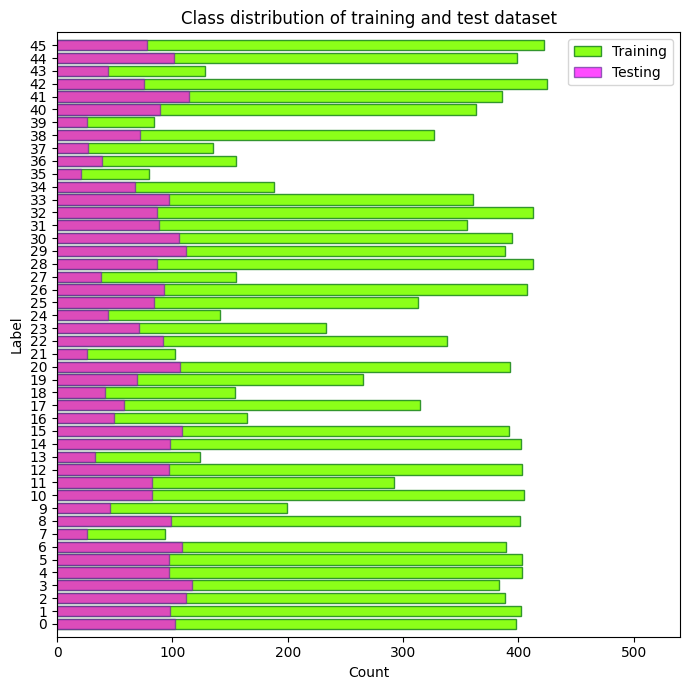

In [77]:
plt.figure(figsize = (7,7))
plt.title("Class distribution of training and test dataset")
plt.barh(label_train, counts_train, color = "chartreuse", label = "Training", edgecolor = "forestgreen", alpha = .9) # tu green "#639A00"
plt.barh(label_test, counts_test, color = "fuchsia", label = "Testing", edgecolor = "rebeccapurple", alpha = .7) # tu orange "#CA7406"
plt.xlabel('Count')
plt.ylabel('Label')
plt.xlim(0, 540)
plt.ylim(-1, 46)
plt.yticks(range(0, 46),range(0, 46))
plt.legend()
plt.tight_layout()

plt.savefig("../../plots/class_distributions.pdf")

In [8]:
length_test = df_test.groupby("label")["length_seconds"].sum()
label_test = length_test.index
length_test = length_test.values

length_train = df_train.groupby("label")["length_seconds"].sum()
label_train = length_train.index
length_train = length_train.values

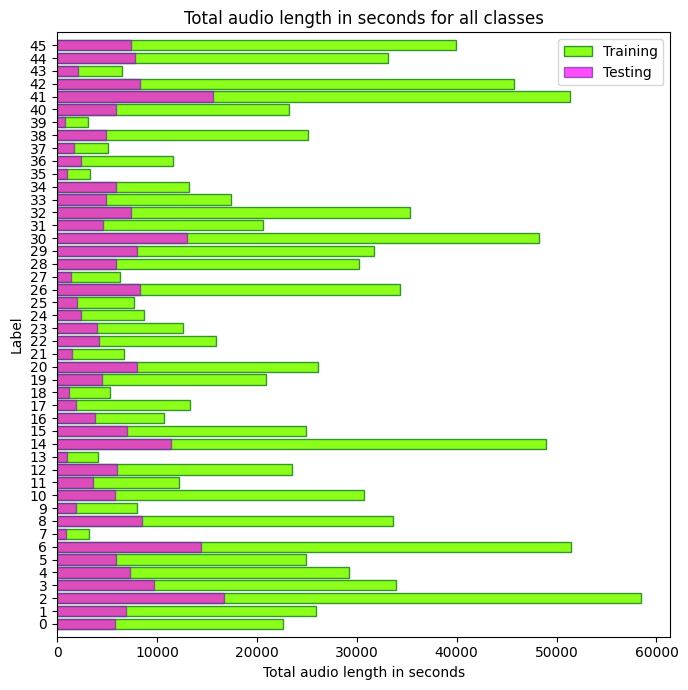

In [9]:
plt.figure(figsize = (7,7))
plt.title("Total audio length in seconds for all classes")
plt.barh(label_train, length_train, color = "chartreuse", label = "Training", edgecolor = "forestgreen", alpha = .9) # tu green "#639A00"
plt.barh(label_test, length_test, color = "fuchsia", label = "Testing", edgecolor = "rebeccapurple", alpha = .7) # tu orange "#CA7406"
plt.xlabel('Total audio length in seconds')
plt.ylabel('Label')
#plt.xlim(0, 540)
plt.ylim(-1, 46)
plt.yticks(range(0, 46),range(0, 46))
plt.legend()
plt.tight_layout()

In [10]:
length_test = df_test.groupby("label")["length_seconds"].mean()
label_test = length_test.index
length_test = length_test.values

length_train = df_train.groupby("label")["length_seconds"].mean()
label_train = length_train.index
length_train = length_train.values

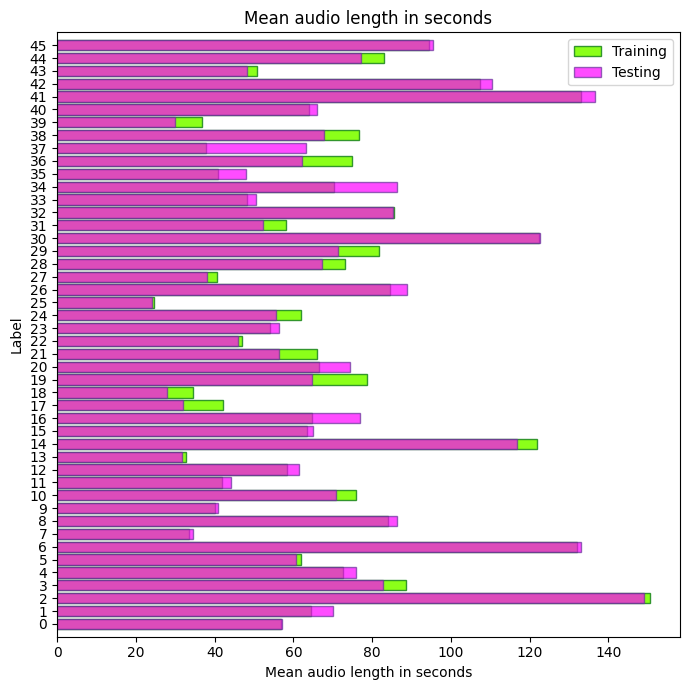

In [11]:
plt.figure(figsize = (7,7))
plt.title("Mean audio length in seconds")
plt.barh(label_train, length_train, color = "chartreuse", label = "Training", edgecolor = "forestgreen", alpha = .9) # tu green "#639A00"
plt.barh(label_test, length_test, color = "fuchsia", label = "Testing", edgecolor = "rebeccapurple", alpha = .7) # tu orange "#CA7406"
plt.xlabel('Mean audio length in seconds')
plt.ylabel('Label')
#plt.xlim(0, 540)
plt.ylim(-1, 46)
plt.yticks(range(0, 46),range(0, 46))
plt.legend()
plt.tight_layout()

# Audio wav forms and spectrograms

In [79]:
df_train.fullfilename = "../" + df_train.fullfilename

In [80]:
from functions import load_spectrogram_slice, load_random_spec_slice
ID = 1337
name = df_train.spectrogram.iloc[ID]
hdf5_path = os.path.dirname(df_train.fullfilename.iloc[ID]) + "/spectrograms.h5"

spec = load_spectrogram_slice(hdf5_path, name, start_row = 0, end_row =None, start_col = 0, end_col = None)

In [81]:
df_train.en.iloc[ID]

'Great Tit'

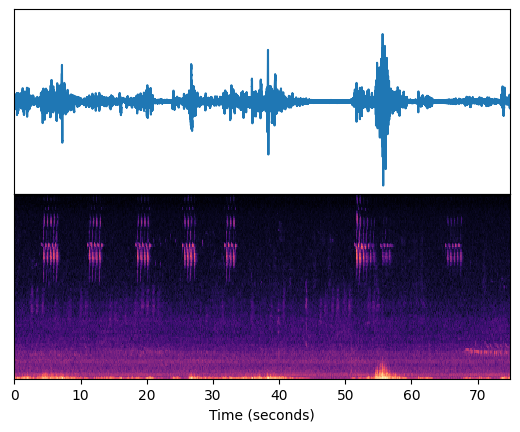

In [82]:
fig, ax = plt.subplots(2,1)
fig.subplots_adjust(hspace=0)
audio, sr = librosa.load(df_train.fullfilename.iloc[ID], sr = cfg.sr)
time = np.linspace(0, len(audio) / sr, num=len(audio))
ax[0].plot(time, audio)
ax[0].set_xlim(0, len(audio) / sr)
ax[0].set_ylim(-1.1*max(np.abs(audio)), 1.1*max(np.abs(audio)))
ax[0].set_xticks([])
ax[0].set_yticks([])

librosa.display.specshow(spec, sr=cfg.sr, hop_length=cfg.hop_length, x_axis='s', ax=ax[1]);

fig.savefig("../../plots/wav_spec.pdf")

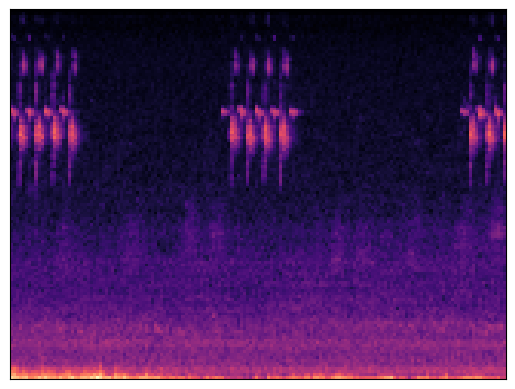

In [168]:
i = 50
spec = load_spectrogram_slice(hdf5_path, name, start_row = 0, end_row =None, start_col = i, end_col = i+162)

fig, ax = plt.subplots(1,1)
librosa.display.specshow(spec, sr=cfg.sr, hop_length=cfg.hop_length, ax=ax);

fig.savefig("../../plots/input.pdf")

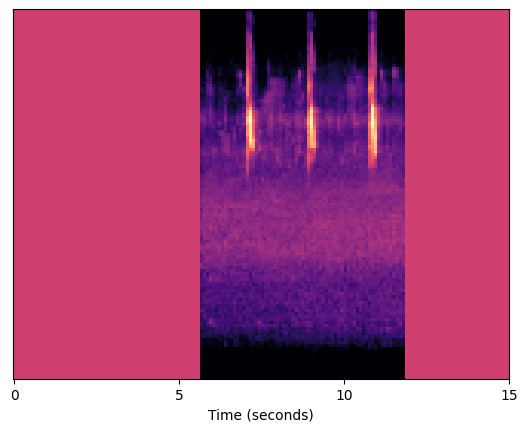

In [177]:
spec = load_random_spec_slice(df_train[df_train.length_spectrogram < 130], 8)
fig, ax = plt.subplots(1,1)
librosa.display.specshow(spec, sr=cfg.sr, hop_length=cfg.hop_length, x_axis='s', ax=ax);

fig.savefig("../../plots/padded.pdf")

In [174]:
import tensorflow_extra as tfe

In [96]:
tfm_layer = tfe.layers.TimeFreqMask(freq_mask_prob=0.5,
                                  num_freq_masks=2,
                                  freq_mask_param=15,
                                  time_mask_prob=0.5,
                                  num_time_masks=3,
                                  time_mask_param=15,
                                  time_last=True)

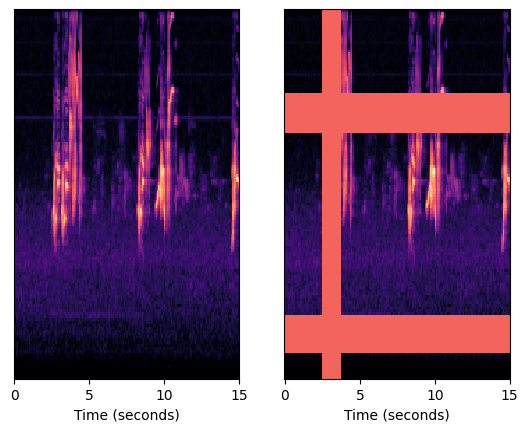

In [184]:
spec = load_random_spec_slice(df_train, 80)
fig, ax = plt.subplots(1,2, figsize = ())

librosa.display.specshow(spec, sr=cfg.sr, hop_length=cfg.hop_length,
                         x_axis='s', ax=ax[0]);

librosa.display.specshow(tfm_layer(spec.reshape(1, *cfg.input_dim, 1), training = True).numpy().reshape(*cfg.input_dim),
                         sr=cfg.sr, hop_length=cfg.hop_length, x_axis='s', ax=ax[1]);

In [185]:
fig.savefig("../../plots/tfm.pdf")